In [2]:
import JSON
using CelestialCalc, Plots, Dates, TimeZones

In [211]:
function brightstars_catalog_orion()
  filename = "./data/BSC_orion.json"
  catalog = JSON.parsefile(filename)
  [parsecatalog(star) for star in catalog]
end

function brightstars_catalog()
  filename = "./data/BSC.json"
  catalog = JSON.parsefile(filename)
  [parsecatalog(star) for star in catalog]
end

function parsecatalog(star)
  α = parse_α(star["RA"])
  δ = parse_δ(star["DEC"])
  mag = parse(Float64, star["MAG"])
  return (EquatorialCoordinates(α,δ),mag)
end

function parse_α(input)
  (h, m, s) = map(x -> parse(Float64, x), split(input, ":"))
  (mi,s) = modf(s)
  return Time(h,m,s,round(mi*1000))
end

function parse_δ(input)
  (deg,m,s) = map(x -> parse(Float64, x), split(input, ":"))
  dec = Angle(abs(deg), m, s, deg < 0)
  return angle_to_decimal(dec)
end

function simple_projection(hcoords::HorizonCoordinates)
  (; h, Az) = hcoords
  x = cosd(h)sind(Az)
  y = cosd(h)cosd(Az)
  return [x;y]
end

function stereographic_projection(hcoords::HorizonCoordinates; R=1)
  (; h, Az) = hcoords

  x = cosd(h)sind(Az)
  y = cosd(h)cosd(Az)
  z = sind(h)

  x_p = x / (z + 1)
  y_p = y / (z + 1)

  X = R*(1 - x_p)
  Y = R*(1 - y_p)

  return [X;Y]
end

stereographic_projection (generic function with 1 method)

In [231]:
function plotstars(eqcoords::Array{Tuple{EquatorialCoordinates,Float64}}, local_civilian_date, latlong=LatLng(-22.9068, -43.1729); projection=simple_projection, kwargs...)
  horizoncoords = [(equatorial_to_horizon(eqcoord, local_civilian_date, latlong),mag) for (eqcoord,mag) in eqcoords]
  horizoncoords = filter(hc -> hc[1].h >= 0, horizoncoords)
  plotstars(horizoncoords, local_civilian_date, latlong; projection=projection, kwargs...)
end

function plotstars(horizoncoords::Array{Tuple{HorizonCoordinates,Float64}}, local_civilian_date, latlong=LatLng(-22.9068, -43.1729); projection=simple_projection, kwargs...)
  n = length(horizoncoords)
  P = Matrix{Float64}(undef, n, 2)
  [P[i,:] = projection(hcoord[1]) for (i,hcoord) in enumerate(horizoncoords)]

  scatter(
    P[:,1],
    P[:,2];
    markersize=[0.5 + 5*(1-(mag+2)/(8+2))^4 for (_,mag) in horizoncoords],
    color="#fff",
    alpha=[5*(1-(mag+2)/(8+2))^4 for (_,mag) in horizoncoords],
    aspect_ratio=:equal,
    background_color="#222",
    kwargs...
  )
end

plotstars (generic function with 4 methods)

In [213]:
brightstars_coords_full = brightstars_catalog()
orioncoords = brightstars_catalog_orion()
;

In [214]:
brightstars_coords = filter!(bsc -> bsc[2] < 400, brightstars_coords_full)
;

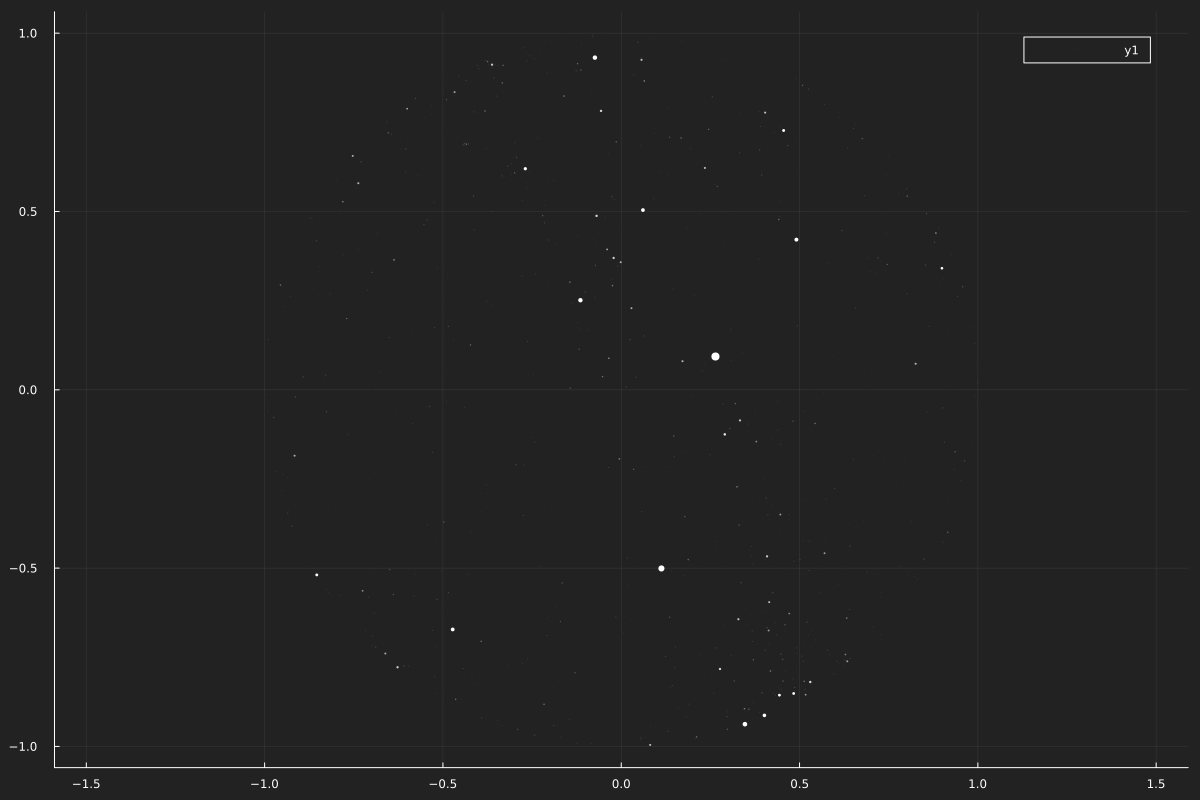

In [237]:
date = ZonedDateTime(2024,1,2,22,45,tz"UTC-3")

# starscoords = orioncoords
starscoords = brightstars_coords

plotstars(starscoords, date; size=(1200,800))

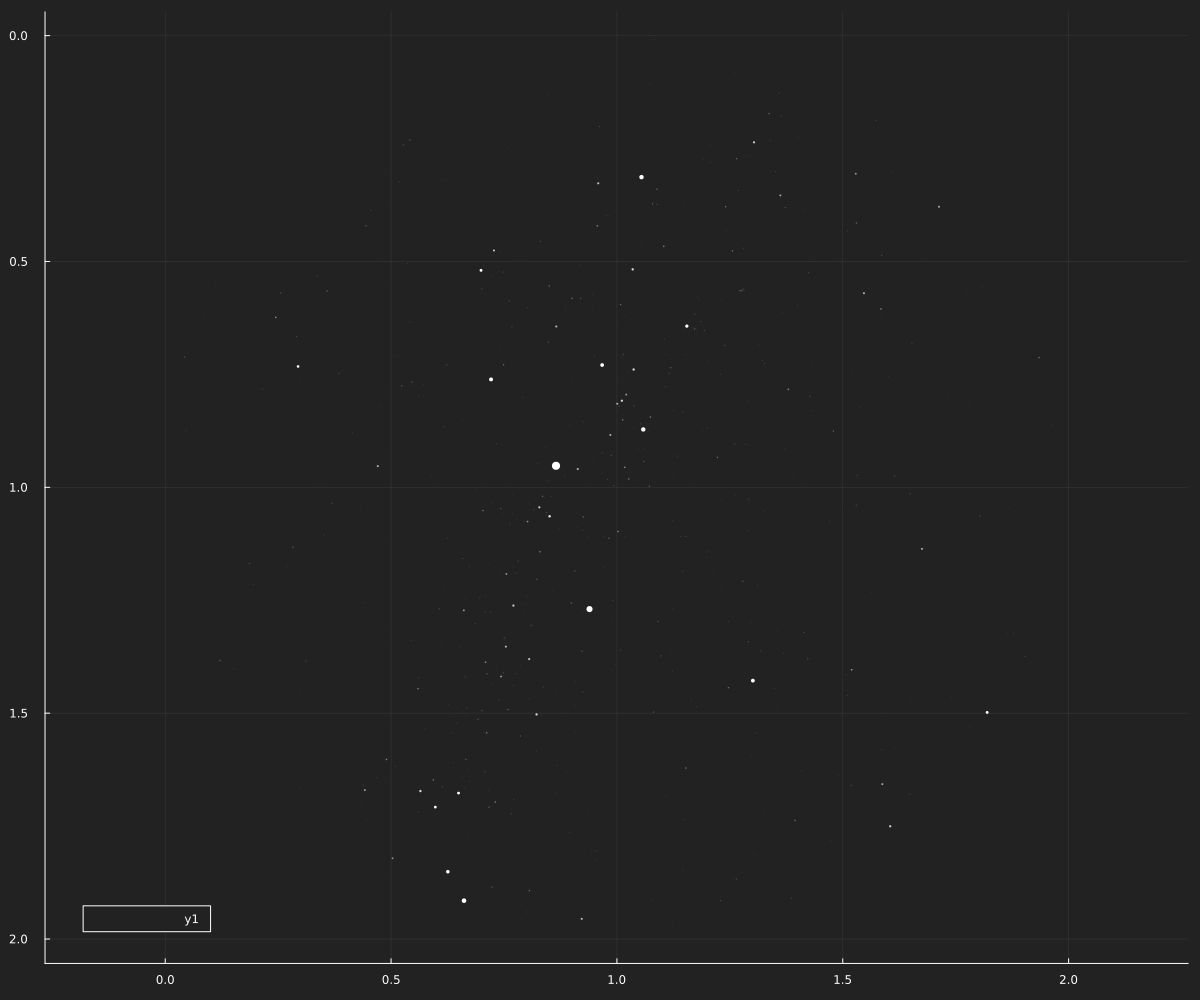

In [239]:
# starscoords = orioncoords
starscoords = brightstars_coords

plotstars(starscoords, date; projection=stereographic_projection, size=(1200,1000), yflip=true)

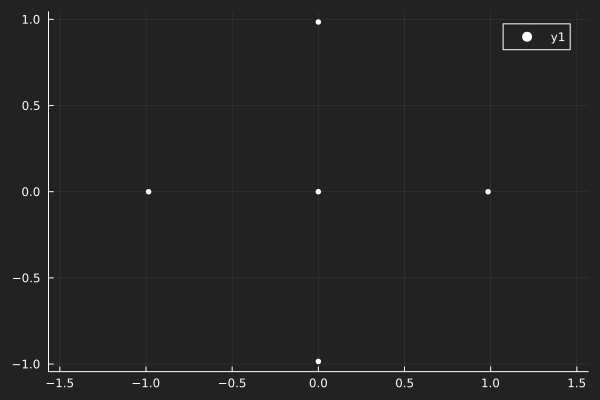

In [97]:
hc = [
  (HorizonCoordinates(10.0,0.0),0.0),
  (HorizonCoordinates(10.0,90.0),0.0),
  (HorizonCoordinates(10.0,180.0),0.0),
  (HorizonCoordinates(10.0,270.0),0.0),
  (HorizonCoordinates(90.0,0.0),0.0),
]
plotstars(hc, date, projection=simple_projection)